#Data Preparation

In [1]:
import numpy
import math
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import GRU
from keras.layers import LSTM

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import tensorflow as tf


pd.set_option("display.max_rows", 1000)#可显示1000行
pd.set_option("display.max_columns", 1000)#可显示1000列
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("/content/drive/My Drive/CA683 Assignment2")
df = pd.read_csv('Premier League_2014_2022.csv')
df = df[df['ranking']!='None']

Mounted at /content/drive/


In [3]:
MOVING_AVERAGE = 5
MINIMUM_RECORD = 160

In [4]:
dict_player = {}
dict_player_name = {}
for player_id in df['player_id'].unique():
  list_rate = list(df[df['player_id']==player_id]['ranking'].astype(float).rolling(MOVING_AVERAGE).mean())
  if(len(list_rate)>=MINIMUM_RECORD):
    dict_player[player_id] = list_rate[MOVING_AVERAGE-1:]
    dict_player_name[player_id] = df[df['player_id']==player_id]['player_name'].unique()[0]

In [5]:
import random
test_player_list = random.sample(dict_player_name.keys(), 10)
test_player_list

[15485, 38433, 3588, 17025, 72890, 15588, 11374, 3698, 46854, 303]

In [6]:
test_player_list = [49180, 28867, 15509, 51581, 37046, 46854, 15485, 59481, 24473, 22689]

# MODEL&CONFIG

In [7]:
def create_inout_sequences(input_data, tw):
    feature_seq = []
    result_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]#预测time_step之后的第一个数值
        feature_seq.append(train_seq)#feature_seq内的数据不断更新，但是总量只有tw个
        result_seq.append(train_label)

    return feature_seq,result_seq
def cal_rmsle(predicted,real):
  sum=0.0
  for x in range(len(predicted)):
    p = np.log(predicted[x]+1)
    r = np.log(real[x]+1)
    sum = sum + (p - r)**2
  return (sum/len(predicted))**0.5

In [8]:
class MODEL_CONFIG:
  TEST_DATA_SIZE = 20
  INITIAL_WINDOW = 60
  WINDOW_LENTH = 20
  Filename = './Comparison_Work/Result.csv'
  Foldername = './Comparison_Work/Pic_Comparison/'
  def __init__(self, \
        LEARNING_RATE = 0.001,\
        TIME_STEP = 10,\
        DENSE = 1,\
        NUM_NODES = 30,\
        EPOCHS = 500,\
        STRUCTURE = 'RNN',\
        OPTIMIZER = 'SGD'):
    self.LEARNING_RATE = LEARNING_RATE
    self.TIME_STEP = TIME_STEP
    self.DENSE = DENSE
    self.NUM_NODES = NUM_NODES
    self.EPOCHS = EPOCHS
    self.STRUCTURE = STRUCTURE
    if OPTIMIZER == "SGD":
      self.OPTIMIZER = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, decay=1e-6, momentum=0.9, nesterov=True)
    if OPTIMIZER == "ADAM":
      self.OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
    if OPTIMIZER == "RMSprop":
      self.OPTIMIZER = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE,rho=0.9,momentum=0.0,epsilon=1e-07,centered=False)

In [9]:
def sliding_cv_fit(data, config, cur_player_id):
  list_mae = []
  list_mse = []
  list_r2 = []
  list_rmsle = []
  list_passtime = []
  #set model
  model = Sequential()
  if config.STRUCTURE == 'RNN':
    model.add(SimpleRNN(config.NUM_NODES, input_shape=(1, config.TIME_STEP)))
  else:
    if config.STRUCTURE == 'GRU':
      model.add(GRU(config.NUM_NODES, input_shape=(1, config.TIME_STEP)))
    else:
      model.add(LSTM(config.NUM_NODES, input_shape=(1, config.TIME_STEP)))
  model.add(Dense(config.DENSE))
  model.compile(loss='mean_squared_error', optimizer=config.OPTIMIZER)


  list_train_pred = []
  list_test_pred = []

  for train_mark in range(config.INITIAL_WINDOW, (len(data)//config.WINDOW_LENTH)*config.WINDOW_LENTH, config.WINDOW_LENTH):
    data_piece = data[train_mark - config.INITIAL_WINDOW : train_mark + config.WINDOW_LENTH]
    data_seq,result_seq = create_inout_sequences(data_piece, config.TIME_STEP)
    
    train_X = np.array(data_seq[:-config.TEST_DATA_SIZE])
    test_X = np.array(data_seq[-config.TEST_DATA_SIZE:])
    train_Y = np.array(result_seq[:-config.TEST_DATA_SIZE])
    test_Y = np.array(result_seq[-config.TEST_DATA_SIZE:])
    
    train_X = np.reshape(train_X, (train_X.shape[0],1,train_X.shape[1]))
    test_X = np.reshape(test_X, (test_X.shape[0],1,test_X.shape[1]))

    T1 = time.time()
    model.fit(train_X, train_Y, epochs=config.EPOCHS, batch_size=1, verbose=0)
    pass_time = time.time() - T1

    trainPredict = model(train_X)
    testPredict = model(test_X)
    if train_mark == config.INITIAL_WINDOW:
      list_train_pred = list_train_pred + list(trainPredict[:,0])
    else:
      list_train_pred = list_train_pred + list(trainPredict[:,0][-config.WINDOW_LENTH:])

    list_test_pred = list_test_pred + list(testPredict[:,0])

    list_mae.append(mean_absolute_error(test_Y, testPredict))
    list_mse.append(mean_squared_error(test_Y, testPredict))
    list_r2.append(r2_score(test_Y, testPredict))
    list_rmsle.append(cal_rmsle(test_Y, testPredict))
    list_passtime.append(pass_time)
  #create figure
  fig_len = len(data) // 10 + 2
  plt.figure(figsize=[fig_len,6])
  plt.plot(range(0,len(data)),data,color='blue')
  len_trainP = len(list_train_pred)
  len_testP = len(list_test_pred)
  plt.plot(range(config.TIME_STEP,config.TIME_STEP+len_trainP),list_train_pred,color='orange')
  plt.plot(range(config.INITIAL_WINDOW,config.INITIAL_WINDOW+len_testP),list_test_pred,color='red')
  plt.legend(['Real', 'Train Predict', 'Test Predict'],loc='best')
  plt.title('Performance of ' + dict_player_name[cur_player_id])

  plt.savefig(config.Foldername + str(cur_player_id) + '.jpg')
  print('\nSave fig to:' + config.Foldername + str(cur_player_id) + '.jpg')
  #plt.show()

  return np.mean(list_mae),np.mean(list_mse),np.mean(list_r2),np.mean(list_rmsle),np.mean(list_passtime)

#RNN

In [10]:
df_RNN_para = pd.read_csv('./Comparison_Work/RNN_ParaResultCV.csv')
df_RNN_para = df_RNN_para.sort_values(by="MSE",ascending=True)
print(df_RNN_para[0:5])

    LEARNING_RATE  TIME_STEP  DENSE  NUM_NODES  EPOCHS OPTIMIZER  TIME_STEP.1  \
9           0.001          6      1         40     400      ADAM          NaN   
21          0.001          7      1         40     400      ADAM          NaN   
3           0.001          6      1         20     500      ADAM          NaN   
23          0.001          7      1         40     500      ADAM          NaN   
7           0.001          6      1         30     500      ADAM          NaN   

         MAE       MSE     RMSLE        R2  
9   0.187822  0.065101  0.030805  0.514504  
21  0.205720  0.071732  0.033416  0.327540  
3   0.218230  0.072009  0.034048  0.234984  
23  0.206363  0.074220  0.032909  0.368549  
7   0.218965  0.074643  0.034163  0.258224  


In [11]:
config_RNN = MODEL_CONFIG(0.001,6,1,40,400,'RNN','ADAM')
config_RNN.Filename = './Comparison_Work/TrainSet60/RNN_Result.csv'
config_RNN.Foldername = './Comparison_Work/TrainSet60/Pic_RNN/'

 10%|█         | 1/10 [02:36<23:32, 156.94s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_RNN/49180.jpg

	TIME_PER_TRAIN(Second):31.194353771209716

	MAE:0.2292673454284667
	MSE:0.08458963298959368
	R2:0.6797682396157448
	RMSLE:0.03372561857971241


 20%|██        | 2/10 [06:19<26:04, 195.61s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_RNN/28867.jpg

	TIME_PER_TRAIN(Second):37.0516547759374

	MAE:0.19172970819473267
	MSE:0.06030369157411273
	R2:0.5643199443394824
	RMSLE:0.032344420391648296


 30%|███       | 3/10 [10:47<26:41, 228.81s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_RNN/15509.jpg

	TIME_PER_TRAIN(Second):33.480590999126434

	MAE:0.19649094319343569
	MSE:0.05991462392110797
	R2:-0.03215628204687873
	RMSLE:0.029955221492719654


 40%|████      | 4/10 [13:48<20:59, 209.86s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_RNN/51581.jpg

	TIME_PER_TRAIN(Second):36.088955307006835

	MAE:0.1821733165740966
	MSE:0.05484865001583061
	R2:-0.8477327420378691
	RMSLE:0.030160099358821933


 50%|█████     | 5/10 [18:25<19:30, 234.13s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_RNN/37046.jpg

	TIME_PER_TRAIN(Second):34.5940720140934

	MAE:0.21557761657238006
	MSE:0.07093954988686371
	R2:0.29112923160169146
	RMSLE:0.033121159993659215


 60%|██████    | 6/10 [20:19<12:52, 193.02s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_RNN/46854.jpg

	TIME_PER_TRAIN(Second):28.22082883119583

	MAE:0.19847670125961298
	MSE:0.059296260794516144
	R2:0.10097447443935373
	RMSLE:0.03148268941324177


 70%|███████   | 7/10 [23:47<09:54, 198.03s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_RNN/15485.jpg

	TIME_PER_TRAIN(Second):34.66408812999725

	MAE:0.20369485886891692
	MSE:0.06833533863169212
	R2:0.1688752548522541
	RMSLE:0.035680549788365386


 80%|████████  | 8/10 [27:29<06:51, 205.53s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_RNN/59481.jpg

	TIME_PER_TRAIN(Second):36.86944731076559

	MAE:0.2445719167391458
	MSE:0.09732471807622478
	R2:0.19180298469851542
	RMSLE:0.03755980357560718


 90%|█████████ | 9/10 [30:45<03:22, 202.53s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_RNN/24473.jpg

	TIME_PER_TRAIN(Second):32.59087085723877

	MAE:0.16522999731699625
	MSE:0.04213270671673978
	R2:0.5280010260729315
	RMSLE:0.02753115840928162


100%|██████████| 10/10 [34:01<00:00, 204.20s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_RNN/22689.jpg

	TIME_PER_TRAIN(Second):32.75999617576599

	MAE:0.17806959692637125
	MSE:0.05065473842742849
	R2:0.15631513189043503
	RMSLE:0.0299709601632157


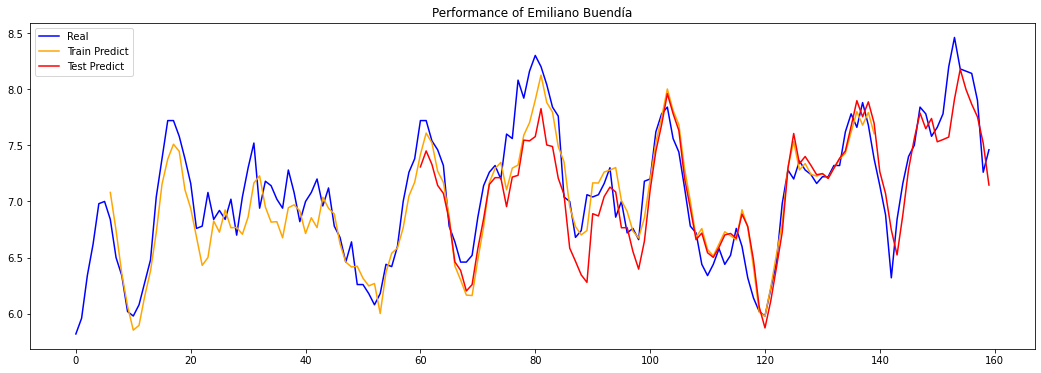

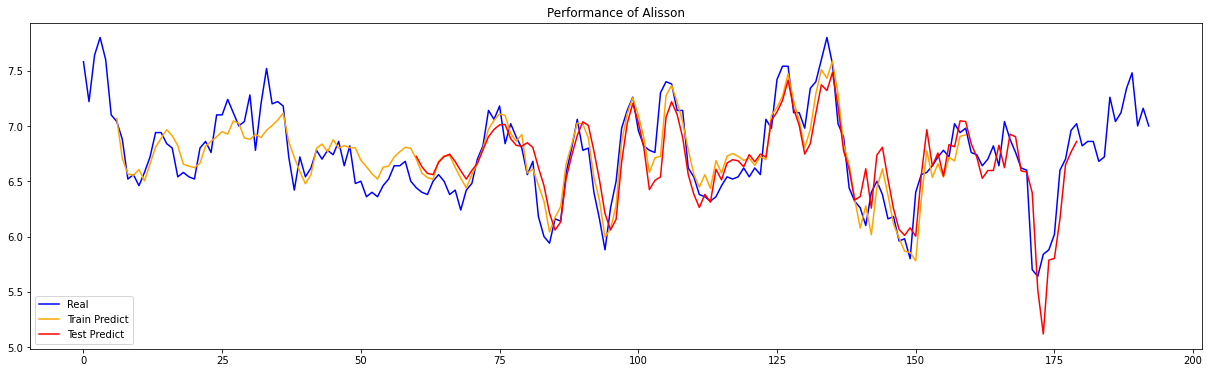

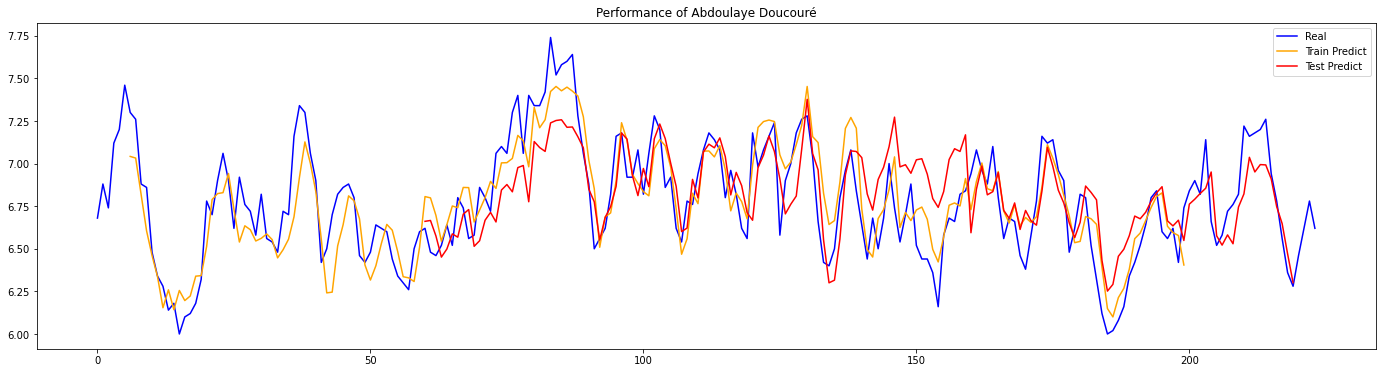

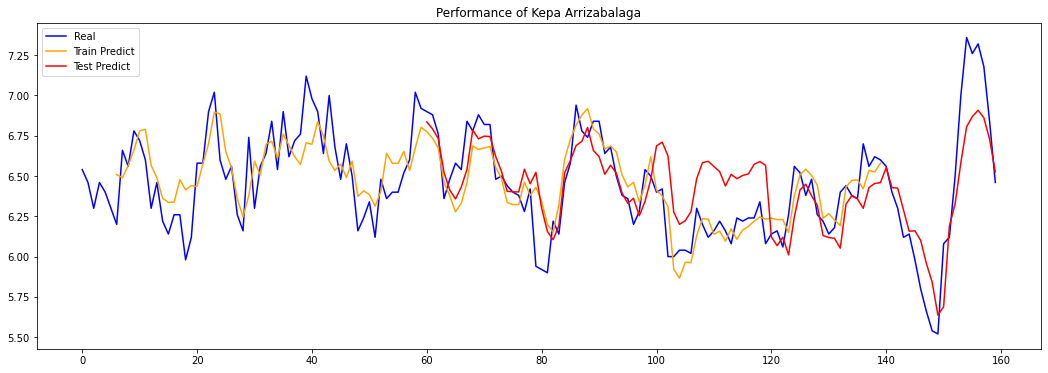

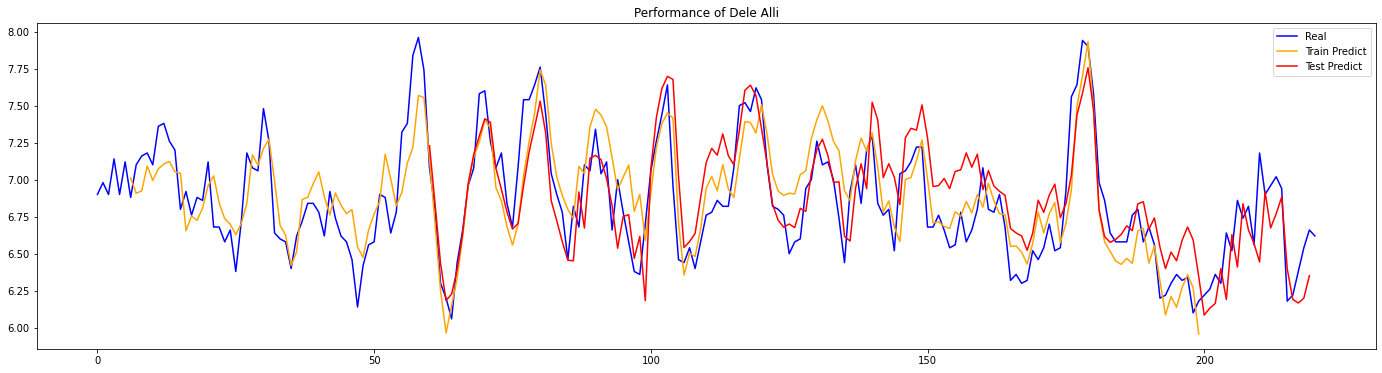

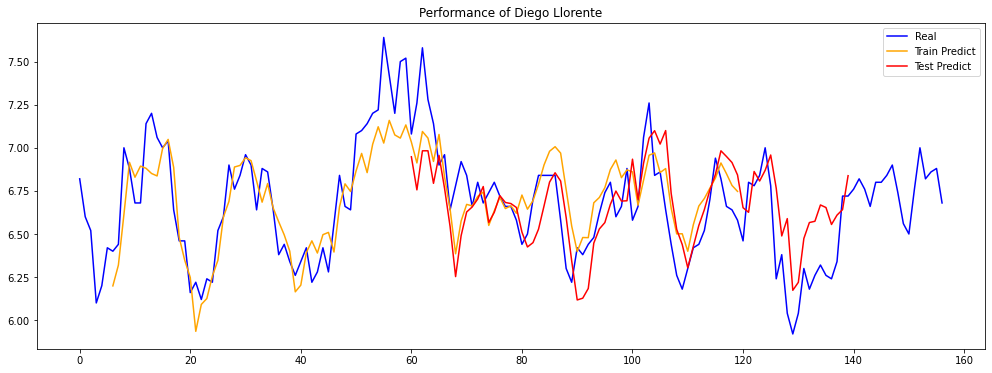

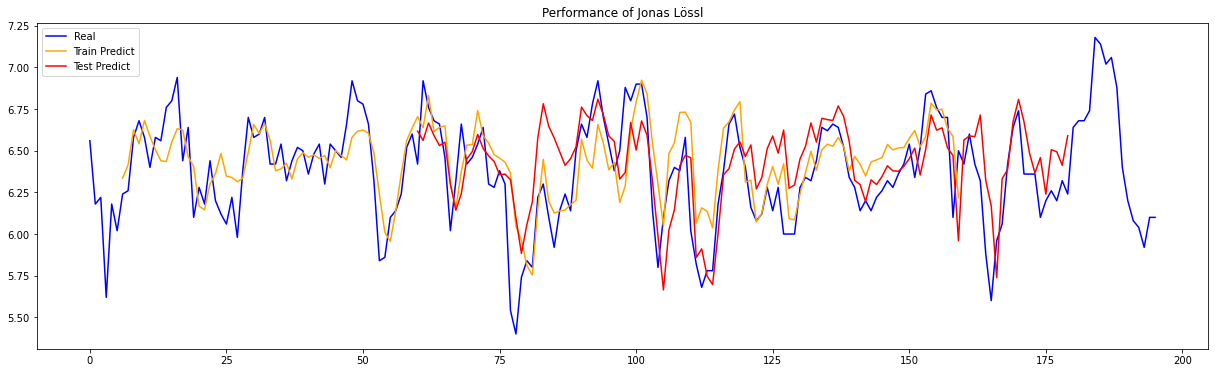

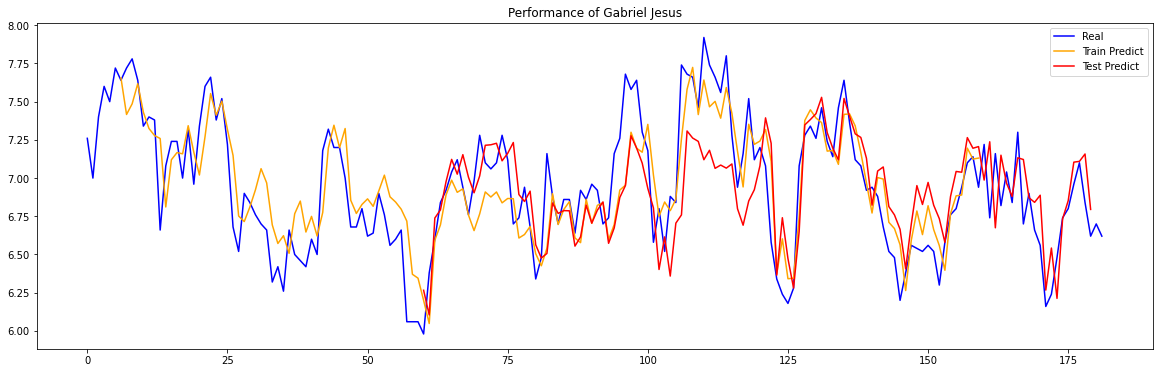

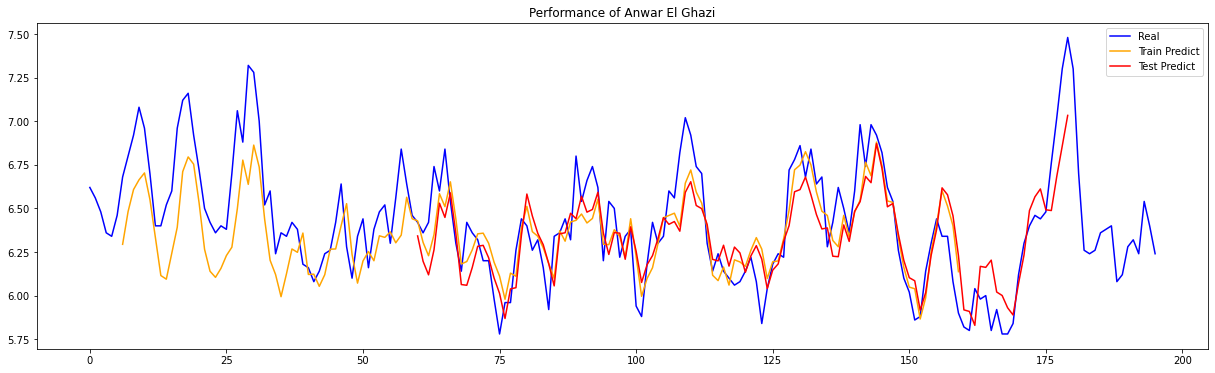

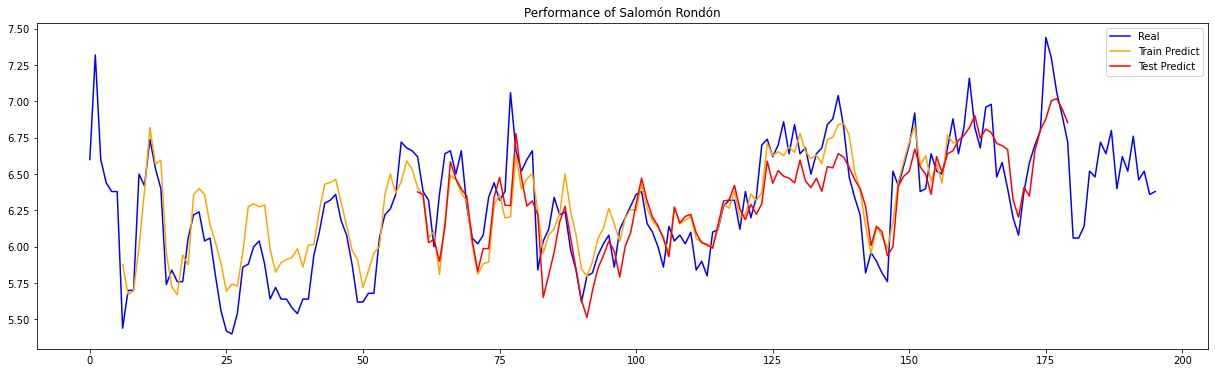

In [12]:
df_result = pd.DataFrame(columns = ['NAME','ID','MAE','MSE','RMSLE','R2'],dtype = float)
for player_id in tqdm(test_player_list):
  data = dict_player[player_id]
  mae,mse,r2,rmsle,passtime = sliding_cv_fit(data, config_RNN, player_id)
  print('\n\tTIME_PER_TRAIN(Second):'+str(passtime))
  print('\n\tMAE:'+str(mae))
  print('\tMSE:'+str(mse))
  print('\tR2:'+str(r2))
  print('\tRMSLE:'+str(rmsle))
  df_result = df_result.append({'NAME':dict_player_name[player_id],\
        'ID':player_id,\
        'MAE':mae,\
        'MSE':mse,\
        'R2':r2,\
        'RMSLE':rmsle,\
        'LENGTH':len(data),\
        'TIME_PER_TRAIN':passtime},ignore_index='true')
df_result.to_csv(config_RNN.Filename,index=0)

#GRU

In [13]:
df_GRU_para = pd.read_csv('./Comparison_Work/GRU_ParaResultCV.csv')
df_GRU_para = df_GRU_para.sort_values(by="MSE",ascending=True)
print(df_GRU_para[0:5])

    LEARNING_RATE  TIME_STEP  DENSE  NUM_NODES  EPOCHS OPTIMIZER  TIME_STEP.1  \
11          0.001          6      1         40     500      ADAM          NaN   
28          0.001          8      1         30     400       SGD          NaN   
23          0.001          7      1         40     500      ADAM          NaN   
9           0.001          6      1         40     400      ADAM          NaN   
7           0.001          6      1         30     500      ADAM          NaN   

         MAE       MSE     RMSLE        R2  
11  0.187576  0.061778  0.030586  0.512846  
28  0.190322  0.062103  0.031119  0.454427  
23  0.196848  0.062525  0.031652  0.370999  
9   0.189588  0.062596  0.030822  0.501661  
7   0.193299  0.062757  0.031032  0.417338  


In [14]:
config_GRU = MODEL_CONFIG(0.001,6,1,40,500,'GRU','ADAM')
config_GRU.Filename = './Comparison_Work/TrainSet60/GRU_Result.csv'
config_GRU.Foldername = './Comparison_Work/TrainSet60/Pic_GRU/'

 10%|█         | 1/10 [05:31<49:39, 331.00s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_GRU/49180.jpg

	TIME_PER_TRAIN(Second):66.09071044921875

	MAE:0.2066117853164672
	MSE:0.07027995493897368
	R2:0.7348980518320161
	RMSLE:0.03126871550259913


 20%|██        | 2/10 [11:00<44:00, 330.12s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_GRU/28867.jpg

	TIME_PER_TRAIN(Second):54.82260684172312

	MAE:0.1912337018648783
	MSE:0.05937623834684975
	R2:0.5619036324197331
	RMSLE:0.03195201391673875


 30%|███       | 3/10 [17:12<40:43, 349.12s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_GRU/15509.jpg

	TIME_PER_TRAIN(Second):46.38836333155632

	MAE:0.20190465378761296
	MSE:0.06152977332760387
	R2:0.019133570646120146
	RMSLE:0.030979145309192074


 40%|████      | 4/10 [22:43<34:11, 341.92s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_GRU/51581.jpg

	TIME_PER_TRAIN(Second):66.06457643508911

	MAE:0.13563739280700685
	MSE:0.032762273248946504
	R2:0.33395364053347787
	RMSLE:0.024081656106210336


 50%|█████     | 5/10 [32:20<35:33, 426.73s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_GRU/37046.jpg

	TIME_PER_TRAIN(Second):72.05911266803741

	MAE:0.18015217709541326
	MSE:0.05106473185960303
	R2:0.560165788011058
	RMSLE:0.02864981476872878


 60%|██████    | 6/10 [35:05<22:31, 337.89s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_GRU/46854.jpg

	TIME_PER_TRAIN(Second):41.232692539691925

	MAE:0.18811278986930846
	MSE:0.050124348608857
	R2:0.17916020027072985
	RMSLE:0.028850743897803222


 70%|███████   | 7/10 [39:54<16:05, 321.93s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_GRU/15485.jpg

	TIME_PER_TRAIN(Second):48.08257273832957

	MAE:0.17691782919565835
	MSE:0.05502537130323478
	R2:0.37466672567796294
	RMSLE:0.03172670895297436


 80%|████████  | 8/10 [45:26<10:50, 325.01s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_GRU/59481.jpg

	TIME_PER_TRAIN(Second):55.17436953385671

	MAE:0.2413592220942178
	MSE:0.09060925596761209
	R2:0.1324698816832
	RMSLE:0.03711074206657689


 90%|█████████ | 9/10 [50:56<05:26, 326.63s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_GRU/24473.jpg

	TIME_PER_TRAIN(Second):54.937409003575645

	MAE:0.19176490243275957
	MSE:0.05325460229112545
	R2:0.397349405749647
	RMSLE:0.030901523992785323


100%|██████████| 10/10 [56:25<00:00, 338.51s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_GRU/22689.jpg

	TIME_PER_TRAIN(Second):54.67115648587545

	MAE:0.20844253953297934
	MSE:0.07005304730003893
	R2:-0.08516465244091327
	RMSLE:0.03449947848119291


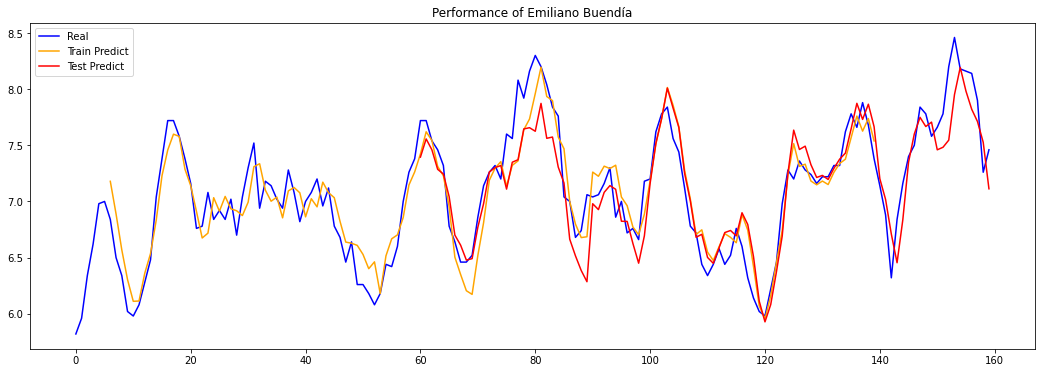

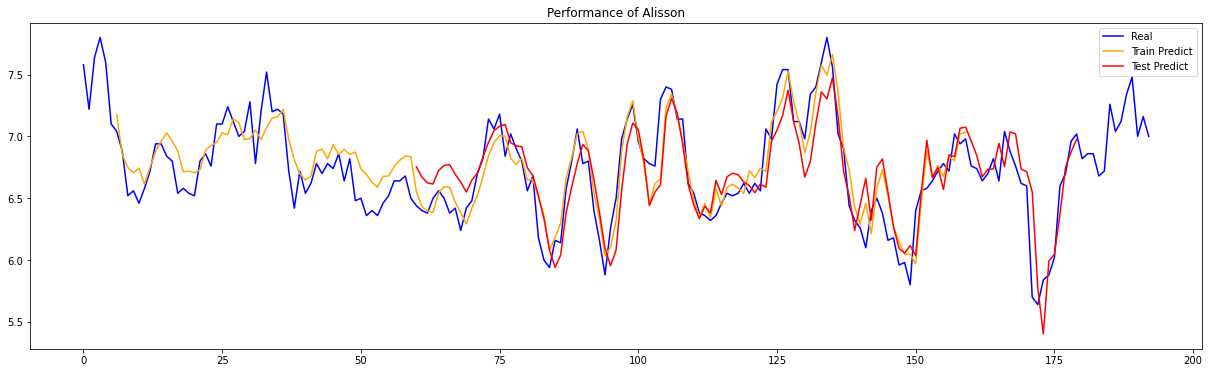

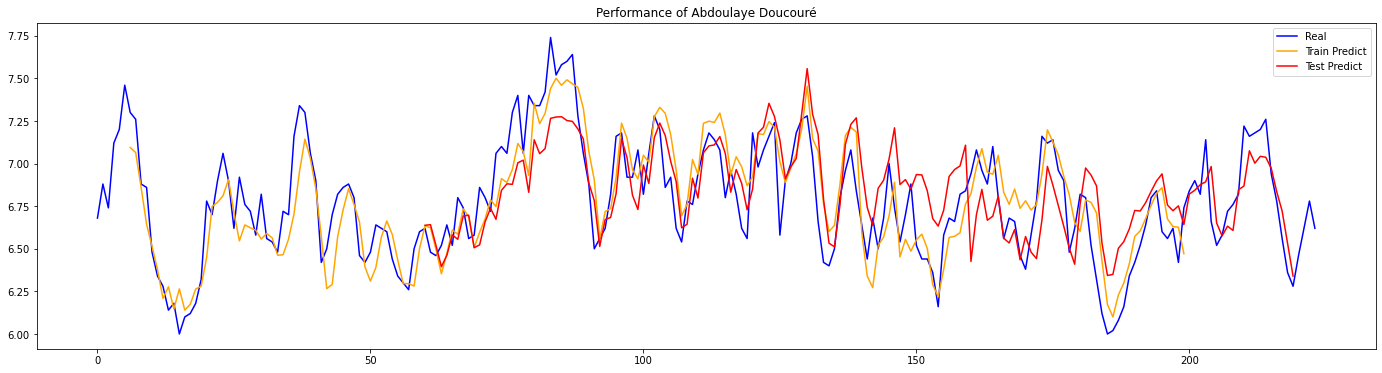

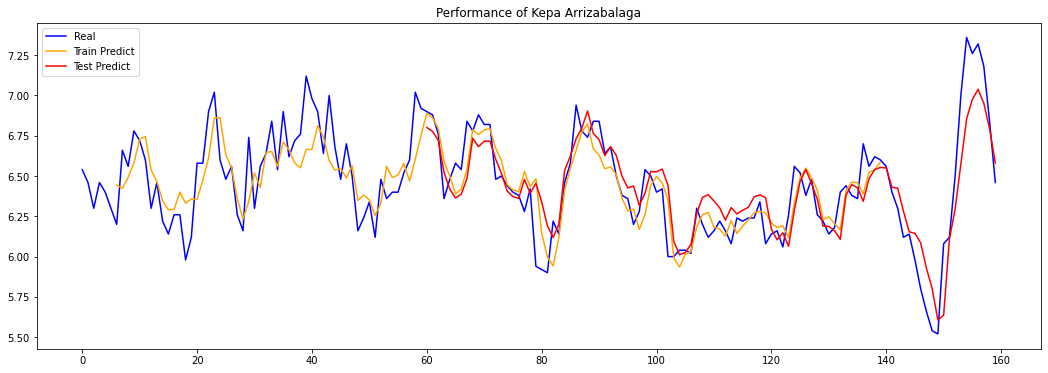

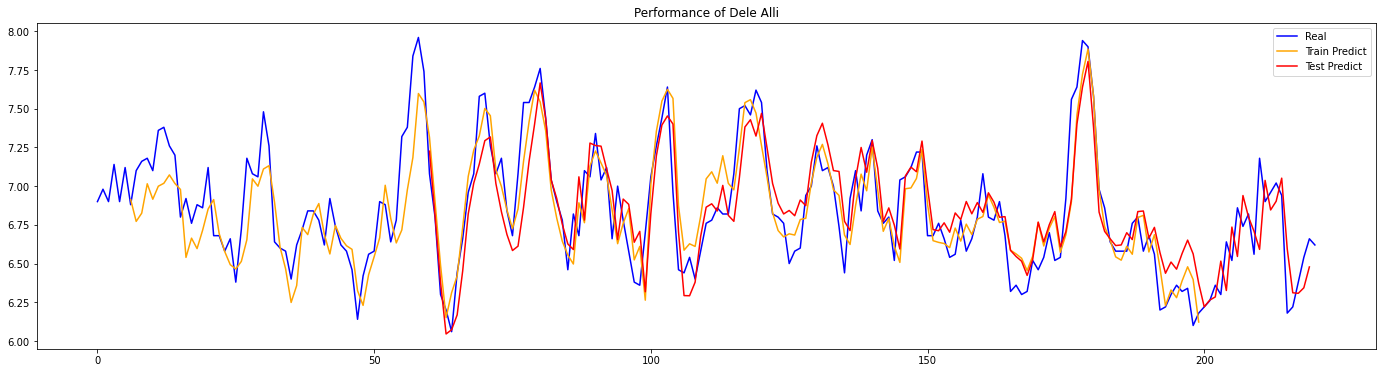

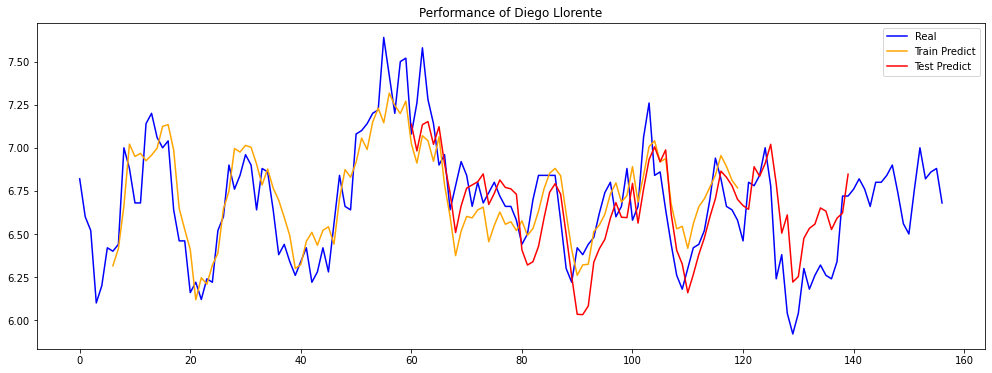

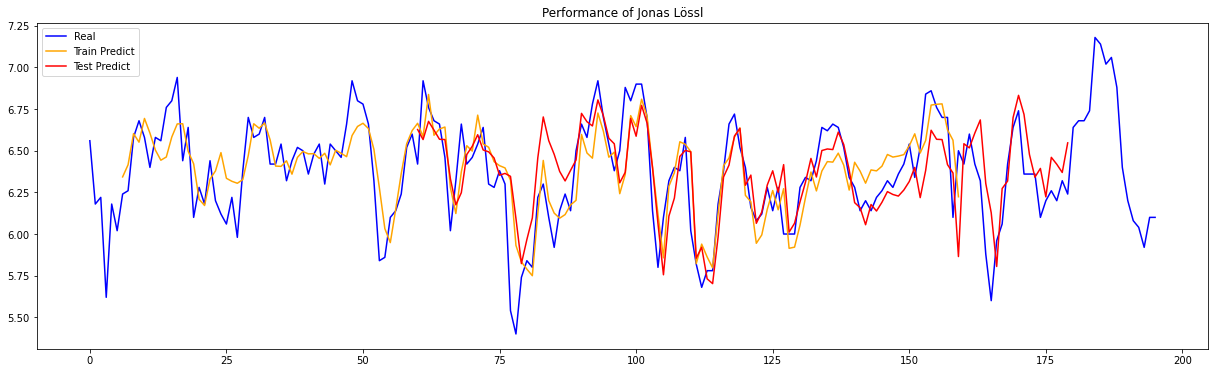

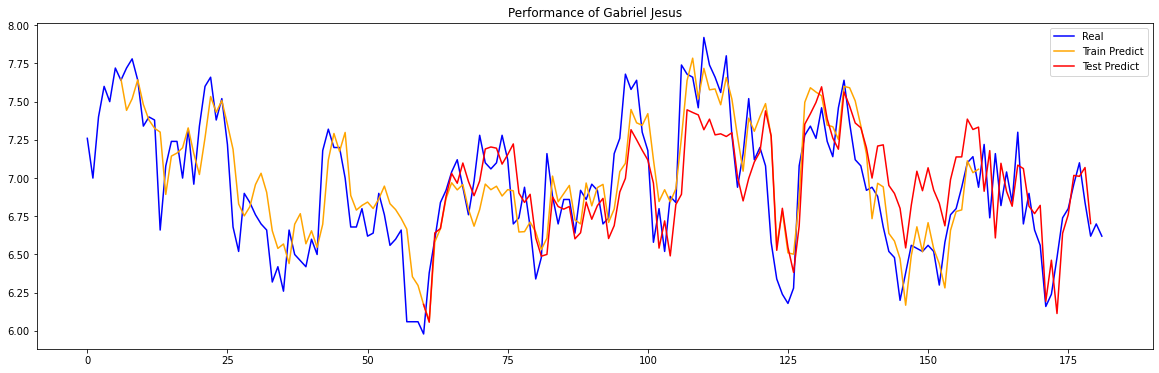

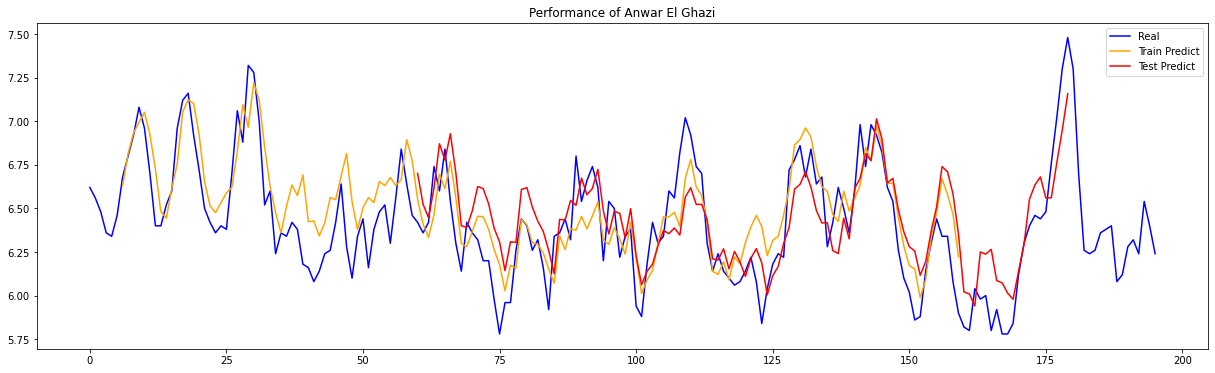

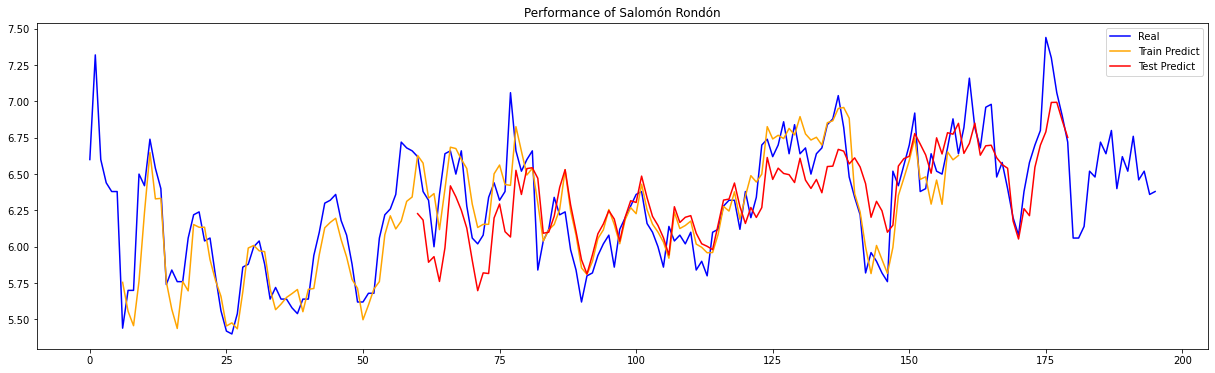

In [15]:
df_result = pd.DataFrame(columns = ['NAME','ID','MAE','MSE','RMSLE','R2'],dtype = float)
for player_id in tqdm(test_player_list):
  data = dict_player[player_id]
  mae,mse,r2,rmsle,passtime = sliding_cv_fit(data, config_GRU, player_id)
  print('\n\tTIME_PER_TRAIN(Second):'+str(passtime))
  print('\n\tMAE:'+str(mae))
  print('\tMSE:'+str(mse))
  print('\tR2:'+str(r2))
  print('\tRMSLE:'+str(rmsle))
  df_result = df_result.append({'NAME':dict_player_name[player_id],\
        'ID':player_id,\
        'MAE':mae,\
        'MSE':mse,\
        'R2':r2,\
        'RMSLE':rmsle,\
        'LENGTH':len(data),\
        'TIME_PER_TRAIN':passtime},ignore_index='true')
df_result.to_csv(config_GRU.Filename,index=0)

#LSTM

In [16]:
df_para = pd.read_csv('ParaResultCV.csv')
df_para = df_para.sort_values(by="MSE",ascending=True)
print(df_para[0:5])

    LEARNING_RATE  TIME_STEP  DENSE  NUM_NODES  EPOCHS OPTIMIZER  TIME_STEP.1  \
23          0.001          7      1         20     500      ADAM          NaN   
34          0.001          7      1         40     500       SGD          NaN   
9           0.001          6      1         30     400      ADAM          NaN   
3           0.001          6      1         20     400      ADAM          NaN   
32          0.001          7      1         40     400       SGD          NaN   

         MAE       MSE     RMSLE        R2  
23  0.179809  0.055023  0.029342  0.516331  
34  0.185452  0.057287  0.030016  0.476154  
9   0.188581  0.059201  0.030295  0.502503  
3   0.189823  0.061629  0.030634  0.485452  
32  0.189335  0.062664  0.030677  0.485385  


In [17]:
config_LSTM = MODEL_CONFIG(0.001,7,1,20,500,'LSTM','ADAM')
config_LSTM.Filename = './Comparison_Work/TrainSet60/LSTM_Result.csv'
config_LSTM.Foldername = './Comparison_Work/TrainSet60/Pic_LSTM/'

 10%|█         | 1/10 [04:23<39:31, 263.54s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_LSTM/49180.jpg

	TIME_PER_TRAIN(Second):52.58303580284119

	MAE:0.22337218742370596
	MSE:0.07719081311050464
	R2:0.7082399931617301
	RMSLE:0.03275550148496252


 20%|██        | 2/10 [08:30<33:51, 253.92s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_LSTM/28867.jpg

	TIME_PER_TRAIN(Second):41.095717231432594

	MAE:0.19503830416997284
	MSE:0.06213550935992886
	R2:0.5271214771568052
	RMSLE:0.03281615761737804


 30%|███       | 3/10 [16:46<42:29, 364.22s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_LSTM/15509.jpg

	TIME_PER_TRAIN(Second):61.85094636678696

	MAE:0.1759556225538254
	MSE:0.0477296177213236
	R2:0.2270897659685225
	RMSLE:0.02737552745139333


 40%|████      | 4/10 [20:57<31:57, 319.59s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_LSTM/51581.jpg

	TIME_PER_TRAIN(Second):50.115886926651

	MAE:0.18972654151916504
	MSE:0.0563028266885484
	R2:-0.7767617492461714
	RMSLE:0.030473645751076184


 50%|█████     | 5/10 [27:07<28:08, 337.79s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_LSTM/37046.jpg

	TIME_PER_TRAIN(Second):46.17784705758095

	MAE:0.1896796327829361
	MSE:0.05550892093777818
	R2:0.5419987369256531
	RMSLE:0.02974448671344477


 60%|██████    | 6/10 [31:14<20:28, 307.02s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_LSTM/46854.jpg

	TIME_PER_TRAIN(Second):61.687477350234985

	MAE:0.1982140417098998
	MSE:0.061709850953056616
	R2:0.06506578038883643
	RMSLE:0.03169353790980459


 70%|███████   | 7/10 [35:22<14:23, 287.72s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_LSTM/15485.jpg

	TIME_PER_TRAIN(Second):41.22973354657491

	MAE:0.18561635557810463
	MSE:0.05978852758007933
	R2:0.3637192757208081
	RMSLE:0.032866099654562386


 80%|████████  | 8/10 [39:30<09:09, 274.89s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_LSTM/59481.jpg

	TIME_PER_TRAIN(Second):41.13404874006907

	MAE:0.23059273974100739
	MSE:0.08624050023578739
	R2:0.16317759609312296
	RMSLE:0.03650864463437842


 90%|█████████ | 9/10 [46:23<05:18, 318.21s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_LSTM/24473.jpg

	TIME_PER_TRAIN(Second):68.80830645561218

	MAE:0.17673495165507003
	MSE:0.04885522486406719
	R2:0.41713211779362586
	RMSLE:0.029633116722459663


100%|██████████| 10/10 [50:30<00:00, 303.07s/it]


Save fig to:./Comparison_Work/TrainSet60/Pic_LSTM/22689.jpg

	TIME_PER_TRAIN(Second):41.08694199721018

	MAE:0.19574421644210815
	MSE:0.06116134692704752
	R2:-0.0017287858700240817
	RMSLE:0.032945523996514736


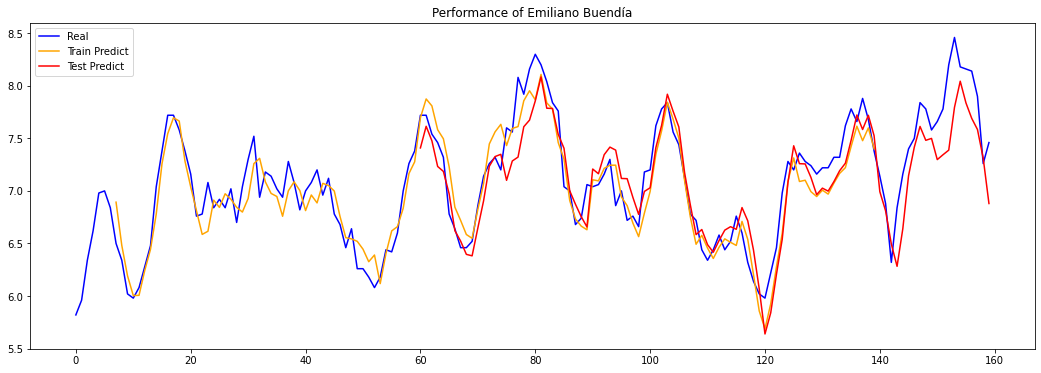

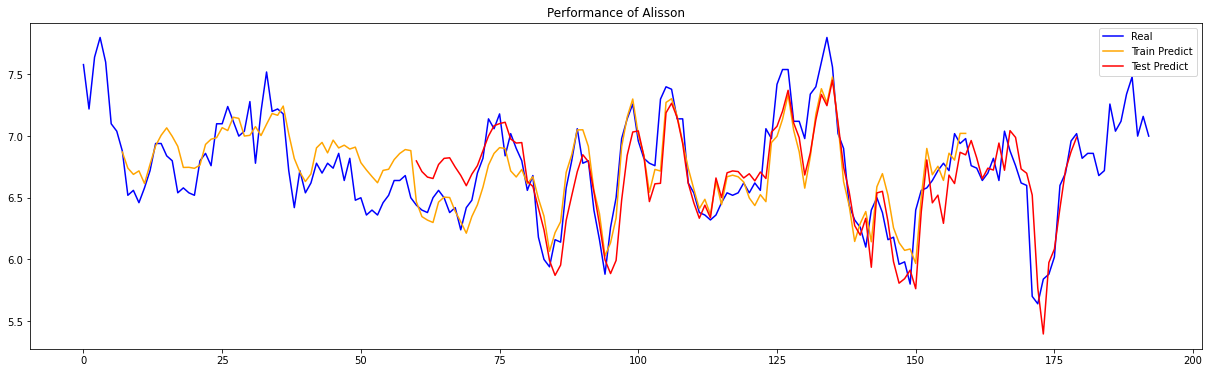

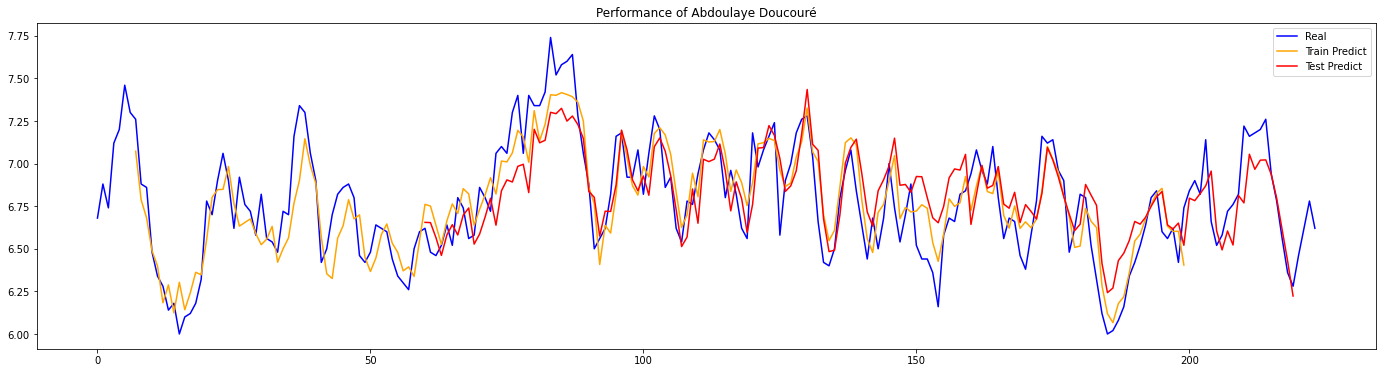

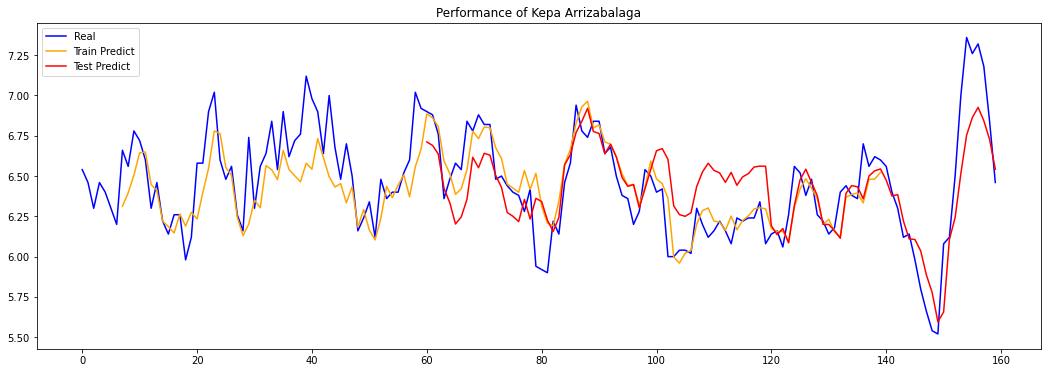

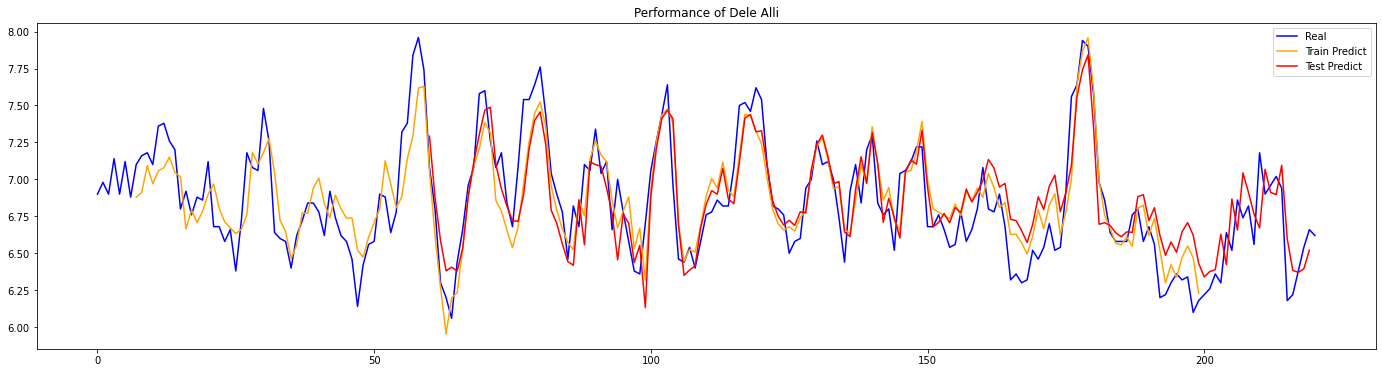

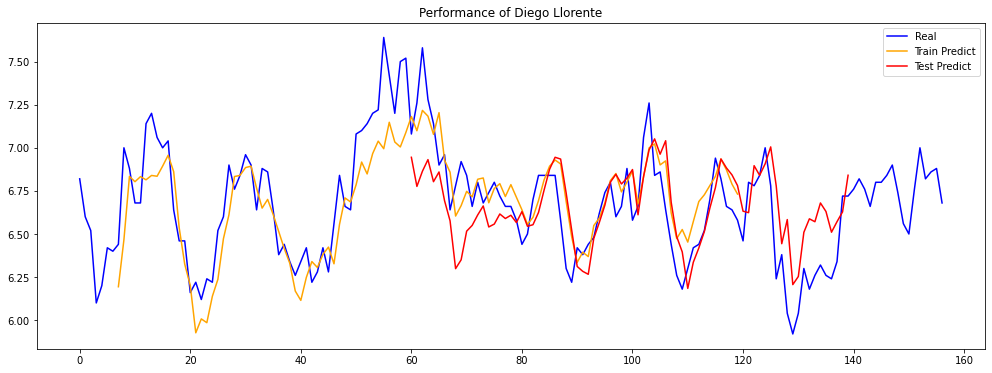

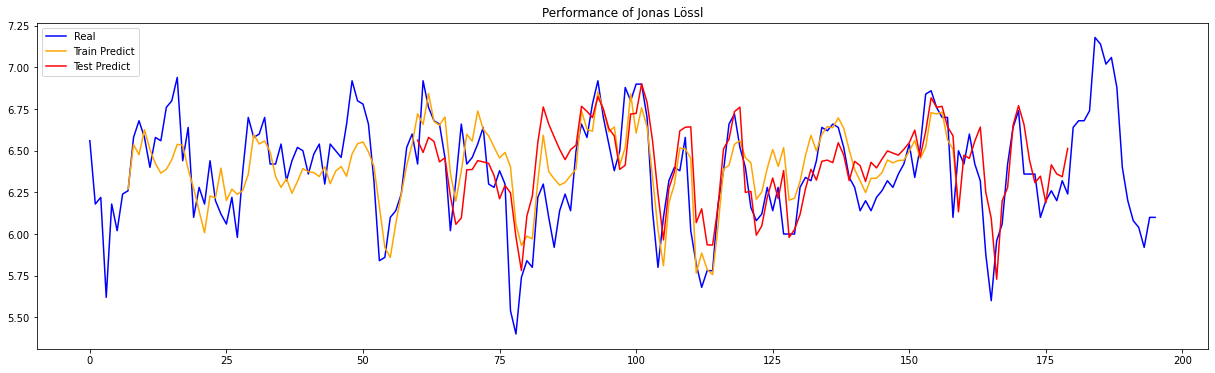

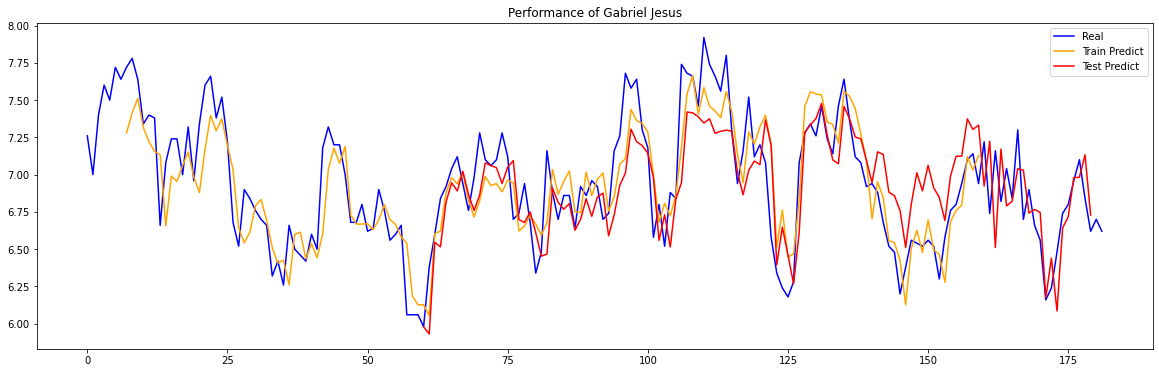

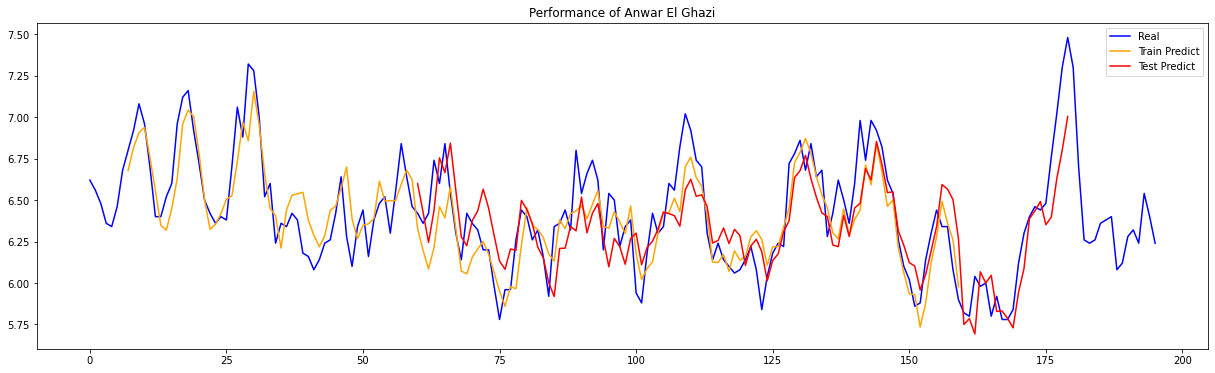

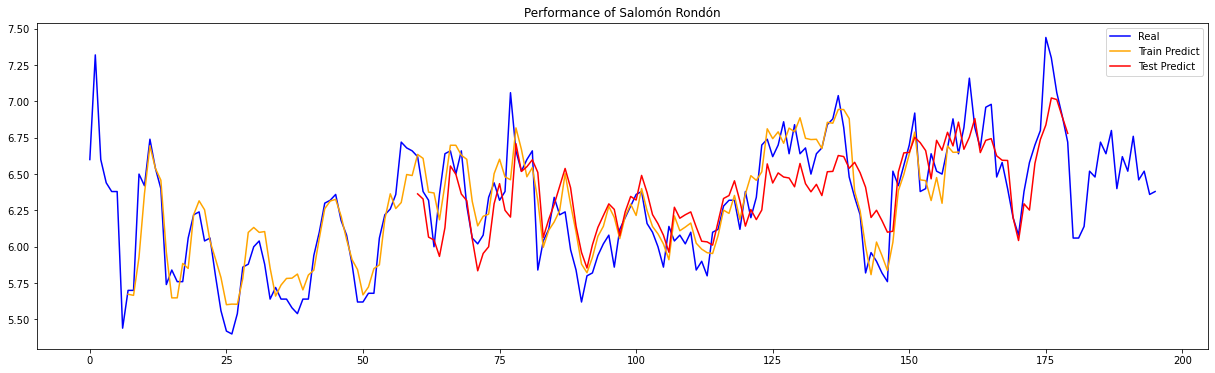

In [18]:
df_result = pd.DataFrame(columns = ['NAME','ID','MAE','MSE','RMSLE','R2'],dtype = float)
for player_id in tqdm(test_player_list):
  data = dict_player[player_id]
  mae,mse,r2,rmsle,passtime = sliding_cv_fit(data, config_LSTM, player_id)
  print('\n\tTIME_PER_TRAIN(Second):'+str(passtime))
  print('\n\tMAE:'+str(mae))
  print('\tMSE:'+str(mse))
  print('\tR2:'+str(r2))
  print('\tRMSLE:'+str(rmsle))
  df_result = df_result.append({'NAME':dict_player_name[player_id],\
        'ID':player_id,\
        'MAE':mae,\
        'MSE':mse,\
        'R2':r2,\
        'RMSLE':rmsle,\
        'LENGTH':len(data),\
        'TIME_PER_TRAIN':passtime},ignore_index='true')
df_result.to_csv(config_LSTM.Filename,index=0)